In [1]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc
import seaborn as sns
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from numpy import dot 
from numpy.linalg import norm
from libpysal.weights.contiguity import Queen
import splot
from esda.moran import Moran
from splot.esda import moran_scatterplot
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
from scipy import stats
from scipy.stats import kurtosis
import os
import copy
import time

mpl.rcParams['axes.unicode_minus'] = False
warnings.simplefilter('ignore')

font_path = r'C:/Users/user/NanumFontSetup_TTF_ALL/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path, size=18).get_name()
rc('font',family=font_name)

# 1. Data Load

In [2]:
data_path = '../data/Dataset' 
os.listdir(data_path)

['fixed_dataset(매출건수).csv',
 'fixed_dataset(자동차유지,10퍼센트절사평균).csv',
 'fixed_dataset(자동차제거,null유지).csv',
 'fixed_dataset(자동차제거,매출log,null유지).csv',
 'fixed_dataset(자동차제거,매출log,null유지,절사평균).csv',
 'fixed_dataset(자동차제거,매출raw,null유지).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,1126).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,1201).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,원래연면적,1201).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,원래연면적,버퍼점포밀도,1202).csv',
 'fixed_dataset.csv',
 'fixed_dataset_1105.csv',
 'fixed_dataset_1214.csv']

In [3]:
# 1. 매출 log, null 유지
data = pd.read_csv(os.path.join(data_path,'fixed_dataset_1214.csv'),encoding='euc-kr')

# 2. 자동차제거,매출log,null유지,절사평균
# data = pd.read_csv(os.path.join(data_path,'fixed_dataset(자동차제거,매출log,null유지,절사평균).csv'),encoding='euc-kr')
data.head()

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,서비스업종다양성,소매업종다양성,상가밀도,주중 / 주말,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,(주거인구+직장인구) / 유동인구,주거인구/직장인구,10_30 / 40_60,점포밀도
0,21300,0.743330,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,0.000,163.106482,...,1.609438,2.390980,86.099041,2.342449,2.695669,31337.73585,0.268398,0.149563,0.406896,7.046875
1,21301,0.121045,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,305.909,156.249615,...,1.127535,1.985080,346.978396,2.315147,2.280277,344640.00000,0.254881,0.667946,0.439757,11.523810
2,21302,0.175777,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,0.000,111.950730,...,2.029155,1.314799,876.110071,2.064957,2.339853,174949.46240,0.220317,0.899425,0.508371,143.584416
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.500,153.728003,...,2.364045,2.064017,232.748015,2.273528,2.246297,97041.79104,0.108296,6.308614,0.441902,36.111111
4,21304,0.073319,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,369.231,177.329451,...,2.289920,2.379112,2495.942389,2.016228,2.004099,166589.33650,0.212989,1.959390,0.479893,113.836066


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BAS_ID               161 non-null    int64  
 1   BAS_AR               161 non-null    float64
 2   도로길이고려_전체통합도         161 non-null    float64
 3   도로길이고려_국부통합도_R3      161 non-null    float64
 4   기초구역평균_전체통합도         161 non-null    float64
 5   기초구역평균_국부통합도_R3      161 non-null    float64
 6   도로율                  161 non-null    float64
 7   평균 도로 길이             161 non-null    float64
 8   아파트시세변화_차분평균         161 non-null    float64
 9   평균영업기간               158 non-null    float64
 10  평균폐업기간               151 non-null    float64
 11  평균최근접역거리             160 non-null    float64
 12  평균최근접정류장거리           160 non-null    float64
 13  건물노후도                161 non-null    float64
 14  공동주택 비율              161 non-null    float64
 15  근린생활시설 비율            161 non-null    flo

## 1.1 결측치 확인

In [5]:
data.isnull().sum()

BAS_ID                  0
BAS_AR                  0
도로길이고려_전체통합도            0
도로길이고려_국부통합도_R3         0
기초구역평균_전체통합도            0
기초구역평균_국부통합도_R3         0
도로율                     0
평균 도로 길이                0
아파트시세변화_차분평균            0
평균영업기간                  3
평균폐업기간                 10
평균최근접역거리                1
평균최근접정류장거리              1
건물노후도                   0
공동주택 비율                 0
근린생활시설 비율               0
단독주택 비율                 0
아파트 가구수                 0
외식업매출월평균변화량             4
서비스업매출월평균변화량            3
소매업매출월평균변화량             5
외식업매출비율                 8
서비스업매출비율                5
소매업매출비율                 5
외식업종다양성                 1
서비스업종다양성                1
소매업종다양성                 1
상가밀도                    1
주중 / 주말                 0
06 to 18 / 18 to 06     0
개별공시지가 변화 차분평균          0
(주거인구+직장인구) / 유동인구      0
주거인구/직장인구               0
10_30 / 40_60           0
점포밀도                    1
dtype: int64

### 1.1.1 평균운영기간, 평균폐업기간
- 영업기간, 폐업기간 둘 다 없을 경우 제거
- 영업기간은 있지만 폐업기간이 없을 경우 영업기간으로 대체
- 점포밀도가 무한대인 row 제거

In [6]:
data[data['평균폐업기간'].isnull()][['BAS_ID','평균영업기간','평균폐업기간','점포밀도']]

,BAS_ID,평균영업기간,평균폐업기간,점포밀도
22,21322,201.466149,NaN,2.666667
27,21327,89.858108,NaN,12.000000
39,21339,82.104355,NaN,0.000000
72,21372,NaN,NaN,28.500000
73,21373,252.747147,NaN,26.633333
75,21375,NaN,NaN,2.000000
81,21381,183.029083,NaN,16.920000
86,21386,132.306618,NaN,10.750000
159,21459,165.177930,NaN,2.666667
160,21460,NaN,NaN,NaN


In [7]:
# 제거할 row 정의 및 제거

drop_index = list(data[data['평균영업기간'].isnull()].index)

clean_data = data.drop(drop_index,axis=0).reset_index(drop=True)

In [8]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BAS_ID               158 non-null    int64  
 1   BAS_AR               158 non-null    float64
 2   도로길이고려_전체통합도         158 non-null    float64
 3   도로길이고려_국부통합도_R3      158 non-null    float64
 4   기초구역평균_전체통합도         158 non-null    float64
 5   기초구역평균_국부통합도_R3      158 non-null    float64
 6   도로율                  158 non-null    float64
 7   평균 도로 길이             158 non-null    float64
 8   아파트시세변화_차분평균         158 non-null    float64
 9   평균영업기간               158 non-null    float64
 10  평균폐업기간               151 non-null    float64
 11  평균최근접역거리             158 non-null    float64
 12  평균최근접정류장거리           158 non-null    float64
 13  건물노후도                158 non-null    float64
 14  공동주택 비율              158 non-null    float64
 15  근린생활시설 비율            158 non-null    flo

In [9]:
condition = clean_data['외식업매출월평균변화량'].isnull() | clean_data['소매업매출월평균변화량'].isnull() 
clean_data[condition].loc[:,['BAS_ID','외식업매출월평균변화량','서비스업매출월평균변화량','소매업매출월평균변화량']]

,BAS_ID,외식업매출월평균변화량,서비스업매출월평균변화량,소매업매출월평균변화량
27,21327,-34481.37931,NaN,NaN
39,21339,-63057.75862,-2.931084e+07,NaN
72,21373,NaN,1.759062e+05,276226.6034
84,21386,-633171.81030,NaN,NaN
109,21411,NaN,-2.047334e+04,-423603.6429


In [10]:
clean_data.fillna(0,inplace=True)

In [11]:
# null값은 없다.
clean_data.isnull().sum()

BAS_ID                 0
BAS_AR                 0
도로길이고려_전체통합도           0
도로길이고려_국부통합도_R3        0
기초구역평균_전체통합도           0
기초구역평균_국부통합도_R3        0
도로율                    0
평균 도로 길이               0
아파트시세변화_차분평균           0
평균영업기간                 0
평균폐업기간                 0
평균최근접역거리               0
평균최근접정류장거리             0
건물노후도                  0
공동주택 비율                0
근린생활시설 비율              0
단독주택 비율                0
아파트 가구수                0
외식업매출월평균변화량            0
서비스업매출월평균변화량           0
소매업매출월평균변화량            0
외식업매출비율                0
서비스업매출비율               0
소매업매출비율                0
외식업종다양성                0
서비스업종다양성               0
소매업종다양성                0
상가밀도                   0
주중 / 주말                0
06 to 18 / 18 to 06    0
개별공시지가 변화 차분평균         0
(주거인구+직장인구) / 유동인구     0
주거인구/직장인구              0
10_30 / 40_60          0
점포밀도                   0
dtype: int64

## 1.2 geometry 정보 로딩

In [12]:
basis_area= gpd.read_file('../data/전처리 파일/부평구_기초구역_5181/부평구_기초구역_4326.shp')
basis_area.head()

,BAS_AR,BAS_ID,BAS_MGT_SN,CTP_KOR_NM,MVMN_DE,MVMN_RESN,NTFC_DE,OPERT_DE,SIG_CD,SIG_KOR_NM,center_x,center_y,geometry
0,2.648838,21459,2823700025,인천광역시,None,None,20121221,None,28237,부평구,126.742914,37.474121,"POLYGON ((126.73590 37.48296, 126.73597 37.482..."
1,0.156212,21384,2823700061,인천광역시,None,None,20121221,None,28237,부평구,126.708049,37.489905,"POLYGON ((126.70977 37.49105, 126.70987 37.491..."
2,0.076024,21403,2823700058,인천광역시,None,None,20121221,None,28237,부평구,126.732706,37.489535,"POLYGON ((126.73383 37.48969, 126.73431 37.489..."
3,0.527205,21447,2823700035,인천광역시,None,None,20121221,None,28237,부평구,126.694834,37.482046,"POLYGON ((126.69892 37.48537, 126.69960 37.485..."
4,0.073898,21421,2823700036,인천광역시,None,None,20121221,None,28237,부평구,126.737058,37.484080,"POLYGON ((126.73785 37.48219, 126.73772 37.482..."


In [13]:
use_basis_area = basis_area[['BAS_ID','geometry']]
use_basis_area.head()

,BAS_ID,geometry
0,21459,"POLYGON ((126.73590 37.48296, 126.73597 37.482..."
1,21384,"POLYGON ((126.70977 37.49105, 126.70987 37.491..."
2,21403,"POLYGON ((126.73383 37.48969, 126.73431 37.489..."
3,21447,"POLYGON ((126.69892 37.48537, 126.69960 37.485..."
4,21421,"POLYGON ((126.73785 37.48219, 126.73772 37.482..."


In [14]:
clean_data['BAS_ID'] = clean_data['BAS_ID'].astype(str) # string 티입으로 변환
clean_data = clean_data.merge(use_basis_area,how='left',right_on='BAS_ID',left_on='BAS_ID').sort_values(by='BAS_ID')
clean_data.head()

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,소매업종다양성,상가밀도,주중 / 주말,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,(주거인구+직장인구) / 유동인구,주거인구/직장인구,10_30 / 40_60,점포밀도,geometry
0,21300,0.743330,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,0.000,163.106482,...,2.390980,86.099041,2.342449,2.695669,31337.73585,0.268398,0.149563,0.406896,7.046875,"POLYGON ((126.69032 37.52345, 126.69084 37.523..."
1,21301,0.121045,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,305.909,156.249615,...,1.985080,346.978396,2.315147,2.280277,344640.00000,0.254881,0.667946,0.439757,11.523810,"POLYGON ((126.69791 37.52246, 126.69791 37.522..."
2,21302,0.175777,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,0.000,111.950730,...,1.314799,876.110071,2.064957,2.339853,174949.46240,0.220317,0.899425,0.508371,143.584416,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.500,153.728003,...,2.064017,232.748015,2.273528,2.246297,97041.79104,0.108296,6.308614,0.441902,36.111111,"POLYGON ((126.70215 37.51767, 126.70204 37.517..."
4,21304,0.073319,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,369.231,177.329451,...,2.379112,2495.942389,2.016228,2.004099,166589.33650,0.212989,1.959390,0.479893,113.836066,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."


In [15]:
center = gpd.GeoDataFrame(clean_data).centroid

clean_data['x'] = center.x
clean_data['y'] = center.y

clean_data.iloc[:,-3:].head()

,geometry,x,y
0,"POLYGON ((126.69032 37.52345, 126.69084 37.523...",126.689135,37.518708
1,"POLYGON ((126.69791 37.52246, 126.69791 37.522...",126.695459,37.522417
2,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.701342,37.522339
3,"POLYGON ((126.70215 37.51767, 126.70204 37.517...",126.698730,37.518981
4,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.703419,37.519319


In [16]:
clean_data.columns

Index(['BAS_ID', 'BAS_AR', '도로길이고려_전체통합도', '도로길이고려_국부통합도_R3', '기초구역평균_전체통합도',
       '기초구역평균_국부통합도_R3', '도로율', '평균 도로 길이', '아파트시세변화_차분평균', '평균영업기간',
       '평균폐업기간', '평균최근접역거리', '평균최근접정류장거리', '건물노후도', '공동주택 비율', '근린생활시설 비율',
       '단독주택 비율', '아파트 가구수', '외식업매출월평균변화량', '서비스업매출월평균변화량', '소매업매출월평균변화량',
       '외식업매출비율', '서비스업매출비율', '소매업매출비율', '외식업종다양성', '서비스업종다양성', '소매업종다양성',
       '상가밀도', '주중 / 주말', '06 to 18 / 18 to 06', '개별공시지가 변화 차분평균',
       '(주거인구+직장인구) / 유동인구', '주거인구/직장인구', '10_30 / 40_60', '점포밀도', 'geometry',
       'x', 'y'],
      dtype='object')

In [17]:
basis_stat = clean_data.iloc[:,1:-3].describe().transpose().apply(lambda x : round(x,4))
basis_stat

,count,mean,std,min,25%,50%,75%,max
BAS_AR,158.0,1.899000e-01,2.579000e-01,3.340000e-02,8.820000e-02,0.1182,0.2089,2.648800e+00
도로길이고려_전체통합도,158.0,3.460538e+02,1.702782e+02,4.846330e+01,2.232449e+02,304.9494,441.1728,9.384161e+02
도로길이고려_국부통합도_R3,158.0,4.082227e+03,2.019466e+03,5.015583e+02,2.664545e+03,3754.0121,5150.0262,1.173155e+04
기초구역평균_전체통합도,158.0,9.470000e-02,1.790000e-02,5.320000e-02,8.480000e-02,0.0953,0.1058,1.795000e-01
기초구역평균_국부통합도_R3,158.0,1.089200e+00,8.480000e-02,8.628000e-01,1.048900e+00,1.0904,1.1414,1.332400e+00
도로율,158.0,2.805440e+01,1.296310e+01,1.400000e-02,1.944000e+01,27.6773,36.1936,6.253530e+01
평균 도로 길이,158.0,1.674987e+02,8.267760e+01,4.905350e+01,1.135915e+02,144.3352,202.4410,5.357467e+02
아파트시세변화_차분평균,158.0,3.022570e+02,6.622982e+02,-8.800000e+02,0.000000e+00,53.3130,379.8075,3.177330e+03
평균영업기간,158.0,1.331065e+02,3.174560e+01,4.118140e+01,1.177432e+02,132.4636,151.0212,2.527471e+02
평균폐업기간,158.0,1.028609e+02,4.568910e+01,0.000000e+00,7.807840e+01,100.6919,126.1925,2.444929e+02


In [18]:
basis_stat.drop(['25%','50%','75%'],axis=1).to_csv('../data/전처리 파일/기초통계량.csv',encoding='euc-kr')

## 1.3 데이터 분포 확인

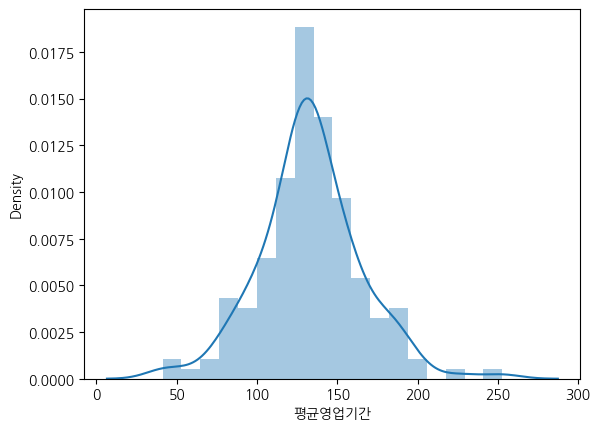

In [19]:
sns.distplot(clean_data['평균영업기간'])
plt.show()

In [20]:
ind_var_col = list(range(1,9)) + list(range(11,35))
dX = clean_data.iloc[:,ind_var_col]

col_list = list(try_data)
nrows = int(len(col_list)/3)+1
ncols = 3

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(15,30),constrained_layout=True)
color = ['red','yellow','navy','green','blue','magenta','violet','skyblue']

for i in range(nrows):
    for j in range(ncols):
        if (ncols*i+j) == len(col_list):
            break
        
        sns.distplot(ax=axes[i,j], x=try_data[col_list[(ncols*i+j)]], kde=True,color=color[(ncols*i+j) % len(color)],rug=True)
        axes[i,j].set_title(col_list[ncols*i+j])

plt.savefig('../data/결과 이미지/기초통계량 분포.jpg')
plt.show()

NameError: name 'try_data' is not defined

## 1.4 다중공선성

In [21]:
def check_vif(dX):
    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(dX.values,i) for i in range(dX.values.shape[1])] 
    vif['features'] = dX.columns
    vif = vif.sort_values("VIF Factor").reset_index(drop=True)
    
    return vif

result = check_vif(clean_data.iloc[:,ind_var_col])
result.iloc[-10:,]

,VIF Factor,features
22,40.004254,소매업매출비율
23,62.069321,서비스업종다양성
24,68.344982,소매업종다양성
25,89.393088,06 to 18 / 18 to 06
26,136.778307,10_30 / 40_60
27,171.930560,도로길이고려_국부통합도_R3
28,186.220858,도로길이고려_전체통합도
29,187.783686,기초구역평균_전체통합도
30,347.106332,주중 / 주말
31,451.039756,기초구역평균_국부통합도_R3


In [22]:
def RFE(df):
    flag = True
    next_col = list(df.columns)
    
    while flag:
        local = df.loc[:,next_col]
        result = check_vif(local)

        if len(result[result['VIF Factor'] > 10]) == 0:
            return result # 유일한 탈출 조건
        
#         display(result[-7:])
        next_col = result.iloc[:-1,1].values.tolist()
        
vif_result = RFE(dX)
optimal_feature = vif_result['features'].values.tolist()
optimal_feature

['외식업매출월평균변화량',
 '소매업매출월평균변화량',
 '아파트시세변화_차분평균',
 '서비스업매출월평균변화량',
 '주거인구/직장인구',
 '아파트 가구수',
 'BAS_AR',
 '단독주택 비율',
 '서비스업매출비율',
 '외식업매출비율',
 '근린생활시설 비율',
 '개별공시지가 변화 차분평균',
 '평균최근접역거리',
 '공동주택 비율',
 '(주거인구+직장인구) / 유동인구',
 '평균 도로 길이',
 '도로길이고려_국부통합도_R3',
 '점포밀도',
 '상가밀도',
 '평균최근접정류장거리']

# 2 OLS

## 2.1 Modeling

In [ ]:
import statsmodels.api as sm

X = clean_data.iloc[:,ind_var_col]
X = sm.add_constant(X)
y = clean_data.loc[:,'평균영업기간'].values
    
ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

## 2.2 변수 특성별 모델링
1. 건축물 특성
    - 단독주택 연면적 비율
    - 공동주택 연면적 비율
    - 근린생활시설 연면적 비율
    - 건물노후도
2. 상권특성
    - 점포일도
    - 상권면적
    - 상가밀도
    - 개별공시지가
    - 아파트 시세 변화
3. 도로특성
    - 도로의 평균 길이
    - 도로율
    - 국부통합도
    - 전체통합도
4. 인구특성
    - 아파트 세대수
    - 외부 유입 인구 비율
    - 상주/직장 인구 비율
    - 방문객 연령
    - 주야간 방문 비율
    - 평일주말 방문 비율
5. 업종특성
    - 외식업, 서비스업, 소매업 업종 다양성
    - 외식업, 서비스업, 소매업 매출 비율
    - 외식업, 서비스업, 소매업 매출 변화율
6. 접근성
    - 지하철역까지의 거리
    - 버스정류장까지의 거리

In [ ]:
building_col = ['단독주택 비율','공동주택 비율','근린생활시설 비율','건물노후도']
market_col = ['점포밀도','BAS_AR','상가밀도','개별공시지가 변화 차분평균','아파트시세변화_차분평균']
road_col = ['평균 도로 길이','도로율','기초구역평균_국부통합도_R3','기초구역평균_전체통합도','도로길이고려_전체통합도'
            ,'도로길이고려_국부통합도_R3']
pop_col = ['아파트 가구수','(주거인구+직장인구) / 유동인구','주거인구/직장인구','06 to 18 / 18 to 06'
           ,'10_30 / 40_60','주중 / 주말']
kind_col = ['외식업종다양성','서비스업종다양성','소매업종다양성','외식업매출월평균변화량','서비스업매출월평균변화량'
            ,'소매업매출월평균변화량','외식업매출비율','서비스업매출비율','소매업매출비율']
close_col = ['평균최근접정류장거리','평균최근접역거리']

col_list = [building_col, market_col, road_col, pop_col, kind_col, close_col]
char_var_list = ['건물 특성','상권 특성','도로 특성','인구 특성','업종 특성','접근성']

In [ ]:
import statsmodels.api as sm

In [ ]:
for col, char in zip(col_list,char_var_list):
    X = clean_data.loc[:,col]
    X = sm.add_constant(X)
    y = clean_data.loc[:,'평균영업기간'].values
    
    ols_model = sm.OLS(y,X)
    results = ols_model.fit()
    print('='*30+char+'='*30)
    display(results.summary())
    print('\n')

## 2.3 특성별 다중공선성 제거

In [ ]:
rm_collinearity = []

for col in col_list:
    result = RFE(clean_data.loc[:,col])
    rm_collinearity.append(result['features'].values)

In [ ]:
building_col = ['단독주택 비율','공동주택 비율','근린생활시설 비율','건물노후도']
market_col = ['점포밀도','BAS_AR','상가밀도','개별공시지가 변화 차분평균','아파트시세변화_차분평균']
road_col = ['평균 도로 길이','도로율','기초구역평균_국부통합도_R3','기초구역평균_전체통합도','도로길이고려_전체통합도'
            ,'도로길이고려_국부통합도_R3']
pop_col = ['아파트 가구수','(주거인구+직장인구) / 유동인구','주거인구/직장인구','06 to 18 / 18 to 06'
           ,'10_30 / 40_60','주중 / 주말']
kind_col = ['외식업종다양성','서비스업종다양성','소매업종다양성','외식업매출월평균변화량','서비스업매출월평균변화량'
            ,'소매업매출월평균변화량','외식업매출비율','서비스업매출비율','소매업매출비율']
close_col = ['평균최근접정류장거리','평균최근접역거리']

In [ ]:
rm_collinearity

In [ ]:
-

# 3. 지리가중회귀분석(MGWR)

## 3.1 독립변수, 종속변수 설정

In [23]:
drop_list = [col for col in list(dX) if '변화' in col]
drop_list += ['건물노후도','BAS_AR','BAS_ID','x','y','평균폐업기간','평균영업기간','geometry']
try_data = clean_data.drop(drop_list,axis=1)

In [24]:
try_data

,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,평균최근접역거리,평균최근접정류장거리,공동주택 비율,근린생활시설 비율,...,외식업종다양성,서비스업종다양성,소매업종다양성,상가밀도,주중 / 주말,06 to 18 / 18 to 06,(주거인구+직장인구) / 유동인구,주거인구/직장인구,10_30 / 40_60,점포밀도
0,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,1.172716,0.129807,52.9,42.0,...,0.806505,1.609438,2.390980,86.099041,2.342449,2.695669,0.268398,0.149563,0.406896,7.046875
1,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,1.696683,0.091841,79.4,20.2,...,1.386294,1.127535,1.985080,346.978396,2.315147,2.280277,0.254881,0.667946,0.439757,11.523810
2,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,1.697811,0.040418,32.7,2.2,...,2.063956,2.029155,1.314799,876.110071,2.064957,2.339853,0.220317,0.899425,0.508371,143.584416
3,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,1.802432,0.183461,31.3,55.9,...,1.386294,2.364045,2.064017,232.748015,2.273528,2.246297,0.108296,6.308614,0.441902,36.111111
4,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,1.604301,0.084995,14.7,37.5,...,2.096203,2.289920,2.379112,2495.942389,2.016228,2.004099,0.212989,1.959390,0.479893,113.836066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,153.150645,2987.551685,0.053224,1.073527,47.846843,118.568545,0.716142,0.044763,32.5,24.5,...,1.690393,2.395908,2.160130,811.656434,2.089179,2.293935,0.168611,8.118938,0.418639,44.145161
154,339.514691,2241.934926,0.179476,0.910954,3.660437,184.741846,0.559030,0.245583,0.0,100.0,...,0.636514,0.000000,0.000000,2.983469,1.449448,3.640312,0.027235,0.013054,0.451702,3.000000
155,546.088235,5760.159505,0.097563,0.969282,21.446923,224.758790,1.370646,0.103238,53.6,37.0,...,1.704551,2.245035,2.397922,186.120614,2.072345,2.291081,0.133531,3.087848,0.535500,7.160000
156,263.517281,3222.709021,0.084734,1.061010,14.367906,152.046143,0.771214,0.111800,52.8,20.4,...,1.680047,2.293040,1.930021,359.872676,2.105405,1.587592,0.403526,16.585638,0.603346,37.450704


In [25]:
remove_vif = RFE(try_data)

In [26]:
remove_vif

,VIF Factor,features
0,1.635111,주거인구/직장인구
1,2.230441,아파트 가구수
2,2.531926,단독주택 비율
3,2.804942,서비스업매출비율
4,3.419717,외식업매출비율
5,3.888754,근린생활시설 비율
6,4.300183,평균최근접역거리
7,5.047518,(주거인구+직장인구) / 유동인구
8,5.534775,공동주택 비율
9,5.857238,평균 도로 길이


In [37]:

s_y1 = clean_data['평균영업기간'].values.reshape((-1,1)) # 종속변수1
s_y2 = clean_data['평균폐업기간'].values.reshape((-1,1)) # 종속변수2

# f1, 120
# ['외식업매출비율', '주거인구/직장인구', '상가밀도', '근린생활시설 비율', '서비스업매출비율', '아파트 가구수', '도로율', '평균최근접역거리']

# 다중공선성 제거
# s_X= clean_data.loc[:,optimal_feature].values
# 

# s_X = try_data.values
s_X = try_data.loc[:,remove_vif['features'].values].values

# 회귀계수간 공선성 제거
# condition number 30을 넘지 않는 상한선
# local_mul_col = ['서비스업매출월평균변화량', '외식업매출비율', 'BAS_AR', '상가밀도','근린생활시설 비율','아파트시세변화_차분평균','아파트 가구수',
#                  '주거인구/직장인구']
#
# s_X = clean_data.loc[:,local_mul_col].values

# s_X = clean_data.loc[:,corr_columns].values


# 회귀계수간 공선성 제거
# local_mul_col = ['BAS_AR', '서비스업매출월평균변화량', '아파트시세변화_차분평균', '소매업매출월평균변화량', '외식업매출비율',
#        '근린생활시설 비율', '단독주택 비율']+외식업매출월평균변화량
# s_X = clean_data.loc[:,local_mul_col].values

# Raw Data
# s_X = clean_data.iloc[:,ind_var_col].values

# 공간적 자기상관성이 있는 column들
# auto_col = ['외식업매출월평균변화량', '주거인구/직장인구', '아파트 가구수', 'BAS_AR', '단독주택 비율', '서비스업매출비율'
#             , '개별공시지가 변화 차분평균', '평균최근접역거리', '(주거인구+직장인구) / 유동인구', '평균 도로 길이',
#              '도로길이고려_국부통합도_R3', '점포밀도', '상가밀도', '평균최근접정류장거리']
# s_X= clean_data.loc[:,auto_col].values

# 왜도 2이상인 데이터 log변환 후, standard scaling 함
# s_X= ss_scaled_dX.values


# 왜도 2이상인 데이터 log변환 후, standard scaling, 다중공선성 제거
# s_X= ss_scaled_dX.loc[:,optimal_feature].values

# s_X = rm_avg_X.values

# p-value 0.5 이상 지워보자
# drop_col = [0,1,2,9,10,13,15]
# drop_col = [optimal_feature[i] for i in range(len(optimal_feature)) if i in drop_col]
# s_X= ss_scaled_dX.loc[:,optimal_feature]
# s_X = s_X.drop(drop_col,axis=1).values

u = clean_data['x'] # 경도
v = clean_data['y'] # 위도
s_coords = list(zip(u,v))

s_X.shape

(158, 12)

## 3.2 MODELING

In [43]:
scaler = MinMaxScaler()
mm_scaled_dX = pd.DataFrame(scaler.fit_transform(try_data.loc[:,remove_vif['feature'].values]),columns=remove_vif['feature'].values)
s_X = mm_scaled_dX.values

In [44]:
#Calibrate MGWR model
# 평균영업기간

mgwr_selector = Sel_BW(s_coords, s_y1, s_X,multi=True,kernel='f2',spherical=True)
mgwr_bw = mgwr_selector.search(criterion='AICc',multi_bw_min=[2])
print(mgwr_bw)
mgwr_model = MGWR(s_coords, s_y1, s_X, mgwr_selector,kernel='f2',spherical=True,hat_matrix=True)
mgwr_results = mgwr_model.fit()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[157. 157.  60. 157. 157. 157.  34. 157. 135. 157. 157. 157. 142.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 158
Number of covariates:                                                    13

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         108893.153
Log-likelihood:                                                    -740.499
AIC:                                                               1506.998
AICc:                                                              1511.935
BIC:                                                             108159.076
R2:                                                                   0.312
Adj. R2:                                                              0.255

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
sns.residplot(x=mgwr_results.y,y=mgwr_results.resid_response, scatter_kws = {'edgecolor':"white", "alpha":0.7}
              , line_kws = {"color":"red"})
plt.show()

In [ ]:
sns.residplot(x=s_y1,y=results.resid, scatter_kws = {'edgecolor':"white", "alpha":0.7}
              , line_kws = {"color":"red"})
plt.show()

### 3.2.1 잔차 Moran's I 확인

In [ ]:
gdf = pd.DataFrame(clean_data.loc[:,'geometry'],columns=['geometry'])
# y = clean_data['평균영업기간'].values

y = mgwr_results.resid_response
w = Queen.from_dataframe(gdf)

moran = Moran(y, w,permutations=999)
moran.I

In [ ]:
print('{:.5f}'.format(moran.p_sim))
# 귀무가설을 기각할 수 없으므로 공간적으로 상관성이 없다고 말할 수 있다.

In [ ]:
import statsmodels.api as sm

X = mm_scaled_dX
    # clean_data.loc[:,remove_vif['features'].values]
X = sm.add_constant(X)
y = clean_data.loc[:,'평균영업기간'].values

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

In [ ]:
gdf = pd.DataFrame(clean_data.loc[:,'geometry'],columns=['geometry'])
# y = clean_data['평균영업기간'].values

y = results.resid
w = Queen.from_dataframe(gdf)

moran = Moran(y, w,permutations=999)
moran.I

In [ ]:
moran.p_sim

### 3.2.2 회귀계수

In [32]:
mgwr_coef_df = pd.DataFrame(mgwr_results.params)
mgwr_coef_df.columns = ['intercept']+remove_vif['features'].values.tolist()
# mgwr_coef_df = mgwr_coef_df[RFE(mgwr_coef_df)]
mgwr_coef_df['x'] = u
mgwr_coef_df['y'] = v
mgwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
# mgwr_coef_df.to_csv('../data/전처리 파일/회귀계수/MGWR 회귀계수(평균영업기간,mm,bisquare,data_1222).csv',index=False,encoding='euc-kr')

In [30]:
mgwr_coef_df = pd.DataFrame(mgwr_results.params,index=clean_data.BAS_ID)
mgwr_coef_df.columns = ['intercept']+list(remove_vif['features'].values)

In [ ]:
mgwr_coef_df

In [ ]:
agg_coef = mgwr_coef_df.describe()

In [ ]:
agg_coef_T = agg_coef.loc[['min','max','mean','std'],:].transpose()
agg_coef_T
agg_coef_T.to_csv('../data/전처리 파일/회귀계수/회귀계수 통계량(평균영업기간).csv',encoding='euc-kr')

In [33]:
from scipy.spatial.distance import cdist
cos_df = pd.DataFrame(cdist(mgwr_coef_df.iloc[:,:-3], mgwr_coef_df.iloc[:,:-3], metric='cosine'),
                      columns = mgwr_coef_df['BAS_ID'],
                      index = mgwr_coef_df['BAS_ID'])
cos_df

BAS_ID,21300,21301,21302,21303,21304,21305,21306,21307,21308,21309,...,21450,21451,21452,21453,21454,21455,21456,21457,21458,21459
BAS_ID,,,,,,,,,,,,,,,,,,,,,
21300,1.110223e-16,0.002024,0.004462,1.501868e-03,0.003471,0.001531,0.000317,0.000244,0.000453,0.000294,...,0.035038,0.028058,0.025093,0.029432,0.033676,0.041785,7.442456e-03,3.802663e-02,0.024985,3.153283e-02
21301,2.024474e-03,0.000000,0.000503,1.268196e-04,0.000349,0.000396,0.000978,0.003597,0.004308,0.001361,...,0.048158,0.040150,0.036745,0.041733,0.046556,0.055778,1.445383e-02,4.762931e-02,0.033112,4.106894e-02
21302,4.461651e-03,0.000503,0.000000,8.416467e-04,0.000157,0.001131,0.002661,0.006625,0.007582,0.003183,...,0.056566,0.048030,0.044412,0.049745,0.054871,0.064643,1.919043e-02,5.240921e-02,0.037554,4.613306e-02
21303,1.501868e-03,0.000127,0.000842,1.110223e-16,0.000411,0.000083,0.000513,0.002821,0.003472,0.000762,...,0.047608,0.039589,0.036177,0.041191,0.046036,0.055247,1.258665e-02,4.334140e-02,0.029633,3.721773e-02
21304,3.471427e-03,0.000349,0.000157,4.106405e-04,0.000000,0.000505,0.001799,0.005334,0.006212,0.002174,...,0.055220,0.046699,0.043082,0.048426,0.053561,0.063295,1.660342e-02,4.724883e-02,0.033270,4.140050e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21455,4.178484e-02,0.055778,0.064643,5.524725e-02,0.063295,0.056685,0.048186,0.037696,0.035792,0.047529,...,0.000315,0.001470,0.002371,0.001222,0.000504,0.000000,4.865037e-02,1.055438e-01,0.088089,9.406583e-02
21456,7.442456e-03,0.014454,0.019190,1.258665e-02,0.016603,0.011782,0.008790,0.006088,0.005859,0.008197,...,0.041492,0.033939,0.030391,0.035163,0.039842,0.048650,1.110223e-16,1.734190e-02,0.008693,1.177637e-02
21457,3.802663e-02,0.047629,0.052409,4.334140e-02,0.047249,0.040257,0.038121,0.035680,0.035563,0.036454,...,0.096154,0.086119,0.081360,0.088024,0.094384,0.105544,1.734190e-02,1.110223e-16,0.001616,7.183902e-04


In [34]:
cos_sim_df = cos_df.apply(lambda x:1-x)

In [35]:
des_cos_sim_df = cos_sim_df.describe()
des_cos_sim_df.loc['min',:].agg(['min','max','mean'])

min     0.843890
max     0.948842
mean    0.893471
Name: min, dtype: float64

In [36]:
import math

math.degrees(np.arccos(0.843890))

32.44679711802137

### 3.2.3 local collinearity 확인

In [ ]:
vdp = pd.DataFrame(mgwr_results.local_collinearity()[1])
vdp.columns = ['Intercept']+list(remove_vif['features'].values)

In [ ]:
vdp = pd.DataFrame(mgwr_results.local_collinearity()[1])
vdp

In [ ]:
# vdp_1 = vdp.iloc[:,1]
# vdp_1[vdp_1 > 0.5]

# for idx, data in vdp.iterrows():
#     mul = data[data.apply(lambda x : x >0.5)]
#     if len(mul) > 1:
#         print('{} : {}'.format(idx,mul[1:]))

In [ ]:
local_con_num = pd.Series(mgwr_results.local_collinearity()[0].flatten())

In [ ]:
local_con_num.sort_values(ascending=False)

In [ ]:
a,b = coef_RFE(clean_data.loc[:,local_mul_col])
display(a.local_collinearity()[0].max())
display(b)

### 3.2.4 Optimal Max Bandwidth

In [ ]:
store_path = '../data/전처리 파일/가중치행렬(mgwr,f3,120)'
bandwidth = []
aicc = []
r2 = []
ll = []
start = 80
end = 120
step = 2

for bw in range(start,end,step):
    gwr_bw = bw
    gwr_model = GWR(s_coords, s_y1, s_X, gwr_bw,kernel='f1',spherical=True)
    gwr_results = gwr_model.fit()
    print('='*30+' RESULT '+'='*30)
    print('Bandwidth : {}, R2 : {:3f}, Log-Likelihood : {:3f}, AICc : {:.3f}'.format(bw,gwr_results.R2,
                                                                              gwr_results.llf,gwr_results.aicc))
    bandwidth.append(bw)
    aicc.append(gwr_results.aicc)
    r2.append(gwr_results.R2)
    ll.append(gwr_results.llf)
#     p_val = spatial_variability(gwr_model,bw,n_iters=1000)
#     print('유의 확률 30% : {}'.format(len(p_val[p_val < 0.3])))
    
#     gwr_coef_df = pd.DataFrame(gwr_results.params)
#     gwr_coef_df.columns = ['intercept']+list(clean_data.iloc[:,ind_var_col].columns)
#     gwr_coef_df['x'] = u
#     gwr_coef_df['y'] = v
#     gwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
#     gwr_coef_df.to_csv('../data/전처리 파일/회귀계수/BW별 회귀계수(AICc)/GWR 회귀계수(평균영업기간,bw_'+str(bw)+',1111).csv',index=False,encoding='euc-kr')
#     weight = pd.DataFrame(mgwr_results.W[2],columns=clean_data['BAS_ID'],index=clean_data['BAS_ID'])
#     weight.to_csv(os.path.join(store_path,'weight('+str(bw)+',f3).csv'),encoding='euc-kr')

aicc_by_bw = pd.DataFrame({'band width':bandwidth,'R2':r2,'Log-Likelihood':ll,'AICc':aicc})

In [ ]:
# Band width에 따른 AICc 그래프
sns.scatterplot(x=aicc_by_bw['band width'],y=aicc_by_bw['AICc'],color='magenta')
plt.show()

In [ ]:
diff_aicc = pd.DataFrame({'Interval':range(0,len(aicc_by_bw['AICc'])-1),'diff':abs(np.diff(aicc_by_bw['AICc']))})

In [ ]:
# AICc 감소폭 그래프

sns.scatterplot(x=diff_aicc['Interval'],y=diff_aicc['diff'],color='violet')
plt.show()

### 3.2.5 Column별 회귀계수 분포

In [ ]:
coef_ols = pd.DataFrame({'columns':['const']+list(remove_vif.features.values)
                            ,'coef':results.params})

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7))

sns.boxplot(data=mgwr_coef_df.iloc[:,1:],ax=ax)
sns.scatterplot(x='columns',y='coef',data=coef_ols.iloc[1:,:],color='magenta',ax=ax)
ax.set_xticklabels(mgwr_coef_df.columns[1:], rotation=45, ha='right')
ax.hlines(y=0,color='red',xmin=0,xmax=14)

plt.savefig('../data/결과 이미지/회귀계수 boxplot(평균폐업기간).jpg')
plt.show()

In [ ]:
coef_df_list = [] # bw별 회귀계수 data frame list, tuple로 저장할것(bandwidth, coef_df)
coef_df_by_col_list = [] # column별 회귀계수 dataframe list
start = 80
end = 130
step = 2

# bw별로 회귀계수 dataframe 생성
for bw in range(start,end,step):
    mgwr_selector = Sel_BW(s_coords, s_y1, s_X,multi=True,kernel='bisquare',spherical=True)
    mgwr_bw = mgwr_selector.search(multi_bw_min=[2],multi_bw_max=[bw])
    mgwr_model = MGWR(s_coords, s_y1, s_X, mgwr_bw_selector,kernel='bisquare',spherical=True)
    mgwr_results = mgwr_model.fit()
    
    mgwr_coef_df = pd.DataFrame(mgwr_results.params)
    mgwr_coef_df.columns = ['intercept']+list(clean_data.iloc[:,ind_var_col].columns)
    mgwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
    coef_df_list.append(tuple((bw,mgwr_coef_df)))

# column별 회귀계수 dataframe list 생성
for i in range(32): 
    coef_df_by_col_list.append(pd.DataFrame(columns=range(start,end,step),index=clean_data['BAS_ID']))

# loop 돌면서 각 컬럼별, bw별 dataframe을 생성
for bw,coef_df in coef_df_list:
    for i in range(32):
        coef_df_by_col_list[i].loc[:,bw] = coef_df.iloc[:,i].values

In [ ]:
# 개별공시지가 회귀계수의 분포를 살펴보자
col_name = '개별공시지가 변화 차분평균'
col_idx = clean_data.columns.values.tolist().index(col_name)
target = coef_df_by_col_list[col_idx]
bas_id = '21300'
# target.loc[bas_id].describe()
sns.distplot(x=target.loc[bas_id])
plt.show()

In [ ]:
bas_id_list = list(clean_data['BAS_ID'])
store_path = '../data/전처리 파일/회귀계수/Column별'

for col in tqdm(list(dX)): 
    if '/' in col:
        col_path = col.replace('/',',')
    else:
        col_path = col
        
    if not os.path.isdir(os.path.join(store_path,col_path)):
        os.mkdir(os.path.join(store_path,col_path))
    
    col_idx = dX.columns.values.tolist().index(col)+1
    target = coef_df_by_col_list[col_idx]
    
    for bas_id in bas_id_list:
        # min값과 max값의 부호가 다른 경우에만 그래프 저장 실행
        if (target.loc[bas_id].min()*target.loc[bas_id].max()) > 0:
            continue
            
        sns.histplot(x=target.loc[bas_id], kde=True,color='violet')
        plt.title(bas_id)
        plt.savefig(os.path.join(store_path,col_path,bas_id+'.png'))
        plt.cla()

In [ ]:
dir_list = os.listdir(store_path)
count = []
for dir_name in dir_list:
    file_num = len(os.listdir(os.path.join(store_path,dir_name)))
    count.append(file_num)
#     print('{} : {}'.format(dir_name,file_num))
    
count_df = pd.Series(count,index=dir_list)
count_df.sort_values(ascending=False)

### 3.2.6 Restriction Distance

In [ ]:
def local_cdist(coords_i, coords, spherical):
    """
    Compute Haversine (spherical=True) or Euclidean (spherical=False) distance for a local kernel.
    """
    if spherical:
        dLat = np.radians(coords[:, 1] - coords_i[1])
        dLon = np.radians(coords[:, 0] - coords_i[0])
        lat1 = np.radians(coords[:, 1])
        lat2 = np.radians(coords_i[1])
        a = np.sin(
            dLat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon / 2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        R = 6371.0
        return R * c
    else:
        return np.sqrt(np.sum((coords_i - coords)**2, axis=1))

In [ ]:
bw_list = range(10,158,10)
pos_count = 158
coords = np.array(s_coords)
eps = 1.0000001

df = pd.DataFrame({'BAS_ID':clean_data['BAS_ID']})

for bw in bw_list:
    max_dis_list = []
    for i in range(pos_count): 
        dis_list = local_cdist(coords[i],coords,True)
        max_dis = np.partition(dis_list,int(bw) - 1)[int(bw) - 1] * eps  #partial sort in O(n) Time
#         print(max_dis)
        max_dis_list.append(max_dis)
    
    df[str(bw)] = max_dis_list

df.head()

In [ ]:
df.describe()

In [ ]:
sns.boxplot(data=df.loc[:,'90':])
plt.savefig('../data/결과 이미지/restrict_bw(평균영업기간).jpg')
plt.show()

In [ ]:
dist_Q3 = dict(df.describe().loc['75%'])
max_dist_dict = dist_Q3
max_dist_dict['158'] = 6.400214
max_dist_dict

In [ ]:
temp_bw = []

for bw in range(10,159):
    start_bw = int(bw / 10)*10
    start_dist = max_dist_dict[str(int(start_bw))]
    
    if start_bw != 150:
        temp_bw.append(start_dist+(max_dist_dict[str(int(start_bw)+10)]-start_dist)/10*(bw-start_bw))
    else:
        temp_bw.append(start_dist+(max_dist_dict[str(int(start_bw)+8)]-start_dist)/8*(bw-start_bw))
    
distance_by_bw = pd.DataFrame({'bw':range(10,159),'distance':temp_bw})

In [ ]:
sns.scatterplot(x=distance_by_bw['bw'],y=distance_by_bw['distance'])
plt.savefig('../data/결과 이미지/restrict_bw_smooth_graph(평균영업기간).jpg')
plt.show()

### 3.2.7 Recursive Local Multicollinearity Elimination 

In [ ]:
def coef_RFE(df):
    flag = True
    next_col = list(df.columns)
    
    while flag:
        
        temp_X = df.loc[:,next_col].values
    
        mgwr_selector = Sel_BW(s_coords, s_y1, temp_X,multi=True,kernel='f1',spherical=True)
        mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
        print(mgwr_bw)
        mgwr_model = MGWR(s_coords, s_y1, temp_X, mgwr_selector,kernel='f1',spherical=True,hat_matrix=True)
        mgwr_results = mgwr_model.fit()
    
        mgwr_coef_df = pd.DataFrame(mgwr_results.params)
        mgwr_coef_df.columns = ['intercept']+next_col
    
        result = check_vif(mgwr_coef_df.iloc[:,1:])
        display(result.iloc[-3:,:])

        if len(result[result['VIF Factor'] > 10]) == 0:
            return mgwr_results, result
            # 유일한 탈출 조건
        
        next_col = result.iloc[:-1,1].values.tolist()
        
result, last_feature = coef_RFE(try_data.loc[:,remove_vif['features'].values])
display(last_feature)
display(result.summary())

In [ ]:
last_feature.to_csv('../data/결과 데이터/회귀계수 간의 다중공선성(평균영업기간).csv',encoding='euc-kr')

In [ ]:
list(last_feature['features'].values)

In [ ]:
cc = pd.Series(result.local_collinearity()[0].flatten(),index=clean_data.loc[:,'BAS_ID'])
cc.max()

## 3.3 Kernel별 GWR Modeling
- bisquare, f1, gaussian
- max bandwidth : 120, 거리제한 O
- 대역폭은 고정되어 있고, 커널별 가중치 자료가 필요한 것이기 때문에 굳이 시간이 오래걸리는 MGWR모델이 아닌 GWR 모델을 생성하여 가중치 자료를 생성

In [ ]:
# 1. Raw Data
rd_X = clean_data.iloc[:,ind_var_col]

ind_dataset = [rd_X]
# [rd_X,remove_high_vif_X,scaled_X,remove_high_vif_scaled_X]
kernel = ['bisquare']
# ,'bisquare']
# ,'f2','f3','gaussian','exponential','bisquare']
max_multi_bw = [120]
# [90,100,110,120]

aicc = []
mbw = []
r2 = []
adj_r2 = []
ker = []
dataset_idx = []
count = 0
start_time = time.time()

for func in kernel:
    for bw in max_multi_bw:
        for i,s_X in enumerate(ind_dataset):
            s_X = s_X.values
            # 모델 생성

#             gwr_selector = Sel_BW(s_coords, s_y1, s_X,kernel=func,spherical=True)
#             gwr_bw = gwr_selector.search(bw_min=[2],multi_bw_max=[bw])
#             print(mgwr_bw)
            gwr_model = GWR(s_coords, s_y1, s_X, bw ,kernel=func,spherical=True)
            gwr_results = gwr_model.fit()
    
            # 평가 지표
            aicc.append(gwr_results.aicc)
            mbw.append(bw)
            r2.append(gwr_results.R2)
            adj_r2.append(gwr_results.adj_R2)
            ker.append(func)
            dataset_idx.append(i)
            weight = pd.DataFrame(gwr_results.W,columns=clean_data['BAS_ID'],index=clean_data['BAS_ID'])
            weight.to_csv('../data/전처리 파일/가중치행렬/weight('+str(bw)+',renew f1,1122).csv',encoding='euc-kr')
            
            print('========================= RESULT =========================')
            print('KERNEL : {}'.format(func))
            print('DATASET NUMBER : {}'.format(i))
            print('R2 : {:.8f}'.format(gwr_results.R2))
            print('Adj. R2 : {:.8f}'.format(gwr_results.adj_R2))
            print('AICc : {:.8f}'.format(gwr_results.aicc))
            print('MAX BANDWIDTH : {:.8f}'.format(bw))
    
            count += 1
            print('진행률 : {0:.2f}%, 소요시간 : {1:.2f}분'.format(count/(len(kernel)*len(ind_dataset)*len(max_multi_bw))*100,(time.time()-start_time)/60))

valid_result = pd.DataFrame({'Data Number':dataset_idx,'Kernel':ker,'R2':r2,'Adj. R2':adj_r2
                             ,'AICc':aicc,'Max Bandwidth':mbw})

## 3.4 거리제한에 따른 회귀계수의 비교

In [ ]:
coef_dir = os.listdir('../data/전처리 파일/회귀계수')
coef_dir

In [ ]:
not_restrict = pd.read_csv('../data/전처리 파일/회귀계수/MGWR 회귀계수(평균영업기간,max_bw_120,거리제한 X,renew f1,1118).csv',encoding='euc-kr')
restrict = pd.read_csv('../data/전처리 파일/회귀계수/MGWR 회귀계수(평균영업기간,max_bw_120,renew f1,1118).csv',encoding='euc-kr')

In [ ]:
not_restrict = not_restrict.drop(['x','y'],axis=1)
restrict = restrict.drop(['x','y'],axis=1)
display(not_restrict.head())
display(restrict.head())

In [ ]:
pd.set_option('display.max_rows',10)

In [ ]:
coef_vif_result = RFE(restrict.iloc[:,:-1])
col = coef_vif_result.features.values.tolist()+['BAS_ID','x','y']
remove_vif = restrict.loc[:,col]
remove_vif.to_csv('../data/전처리 파일/회귀계수/MGWR 회귀계수(평균영업기간,max_bw_120, renew f1,다중공선성 제거,1119).csv',index=False,encoding='euc-kr')

In [ ]:
path = '../data/군집화 결과/renew_f1(영업기간,maxbw120,1118).csv'
cluster_data = pd.read_csv(path,encoding='euc-kr')
cluster_data.head()

In [ ]:
merge_restrict = pd.concat([restrict,cluster_data['open_11cluster']],axis=1)
merge_not_restrict = pd.concat([not_restrict,cluster_data['open_11cluster']],axis=1)

In [ ]:
sorted(cluster_data['open_11cluster'].unique())

In [ ]:
merge_not_restrict['open_11cluster'].unique()

In [ ]:
# 중간 위치의 기초구역 리스트
# 21314, 21315, 21334, 21363, 21376
# 해당 기초구역들만 다른 색으로 표시해보자
store_path = '../data/전처리 파일/회귀계수/거리제한 전후 회귀계수 비교'
# inter_area = [21314, 21315, 21334, 21363, 21376]
# idx = restrict[restrict['BAS_ID'].isin(inter_area)].index

if not os.path.exists(store_path):
    os.mkdir(store_path)

for i,col in enumerate(restrict.columns[:-1]):
    if '/' in col:
        col_path = col.replace('/',',')
    else:
        col_path = col
        
    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,7),sharey=True)
    
    sns.scatterplot(x='BAS_ID',y=col,data = merge_not_restrict,hue='open_11cluster',ax=axes[0],palette="Paired")
    sns.scatterplot(x='BAS_ID',y=col,data = merge_restrict,hue='open_11cluster',ax=axes[1],palette="Paired")
    axes[0].set_title('NOT RESTRICT')
    axes[1].set_title('RESTRICT')
    plt.savefig(os.path.join(store_path,col_path))

In [ ]:
path = '../data/전처리 파일/가중치행렬/가중치행렬(bw별, 거리제한 O)'
weight_name = os.listdir(path)
weight = pd.read_csv(os.path.join(path,weight_name[2]),encoding='euc-kr')

In [ ]:
use_weight = weight[weight > 0].count()
len(use_weight[use_weight < 80])

In [ ]:
scatter_data = pd.concat([clean_data[['BAS_ID','평균영업기간','평균폐업기간']],cluster_data['open_11cluster']],axis=1)
scatter_data.head()

In [ ]:
cluster_num = 11
col_num = 3

fig, axes = plt.subplots(nrows=int(cluster_num / col_num)+1,ncols=col_num,figsize=(20,20))

for i, num in enumerate(sorted(cluster_data['open_11cluster'].unique())):
    temp_df = scatter_data.loc[scatter_data['open_11cluster']==num]
    sns.scatterplot(data=temp_df,x='평균폐업기간',y='평균영업기간',color='magenta',palette='deep',ax=axes[int(i/col_num),i % col_num])
    axes[int(i/col_num),i % col_num].set_title('CLUSTER '+str(num))
    axes[int(i/col_num),i % col_num].hlines(temp_df['평균영업기간'].mean(),0,temp_df['평균폐업기간'].max(),color='blue')
    axes[int(i/col_num),i % col_num].vlines(temp_df['평균폐업기간'].mean(),0,temp_df['평균영업기간'].max(),color='blue')
    
plt.show()